In [1]:
import os
import sys
import json

ROOT = os.path.dirname(os.path.dirname(os.path.abspath('.')))
print("ROOT", ROOT)

ROOT /scratch/cs/world-models/merlerm1/open-world-symbolic-planner


In [2]:
sys.path.append(ROOT)

In [3]:
DOMAIN_PATH = os.path.join(ROOT, 'data', 'planning', 'blocksworld', 'domain.pddl')

In [96]:
RESULTS_PATH = os.path.join(ROOT, 'results', 'planning', 'vila', 'blocksworld', 'simple')
results_file = os.path.join(RESULTS_PATH, 'results_6799611.json') # Qwen2.5-VL 72B w/ CoT
# results_file = os.path.join(RESULTS_PATH, 'results_6803283.json') # Gemma3 27B w/ CoT

with open(results_file, 'r') as f:
    results = json.load(f)
    
print("Model:", results['model'])
problem_keys = [ key for key in results.keys() if 'problem' in key ]
print("Total problems:", len(problem_keys))

Model: Qwen/Qwen2.5-VL-72B-Instruct
Total problems: 10


In [97]:
print("Precomputed stats:")
print(f"Action success rate: {results['statistics']['action_success_rate']:.2f}")
print(f"Action failure rate: {results['statistics']['action_failure_rate']:.2f}")
print(f"Task completion rate: {results['statistics']['task_completion_rate']:.2f}")

Precomputed stats:
Action success rate: 0.37
Action failure rate: 0.63
Task completion rate: 0.50


In [98]:
for problem in problem_keys:
    
    problem_metadata_path = "/".join(problem.split('/')[:-1] + ['metadata.json'])
    metadata_file = os.path.join(ROOT, problem_metadata_path)
    with open(metadata_file, 'r') as f:
        metadata = json.load(f)
    problem_name = problem.split('/')[-1].split('.')[0]
    problem_metadata = metadata[problem_name]
    
    problem_results = results[problem]
    print(f"Problem {problem_name}:")
    print(f"Completed: {problem_results['completed']}")
    print(f"Number of actions taken: {len(problem_results['plans'])}")
    
    reference_plan = problem_metadata['reference_plan']
    print(f"Reference plan length: {len(reference_plan)}")
    extra_actions = len(problem_results['plans']) - len(reference_plan)
    
    problem_results['extra_actions'] = extra_actions
    failed_actions = [action for action in problem_results['actions'] if action['success'] == False]
    print(f"Failed actions: {len(failed_actions)}")
    problem_results['failed_actions'] = len(failed_actions)
    print()

Problem simple_problem_8:
Completed: True
Number of actions taken: 8
Reference plan length: 4
Failed actions: 3

Problem simple_problem_5:
Completed: False
Number of actions taken: 50
Reference plan length: 3
Failed actions: 47

Problem simple_problem_1:
Completed: False
Number of actions taken: 50
Reference plan length: 5
Failed actions: 9

Problem simple_problem_4:
Completed: True
Number of actions taken: 5
Reference plan length: 4
Failed actions: 1

Problem simple_problem_3:
Completed: False
Number of actions taken: 50
Reference plan length: 4
Failed actions: 44

Problem simple_problem_9:
Completed: False
Number of actions taken: 50
Reference plan length: 3
Failed actions: 33

Problem simple_problem_7:
Completed: True
Number of actions taken: 16
Reference plan length: 4
Failed actions: 7

Problem simple_problem_0:
Completed: True
Number of actions taken: 7
Reference plan length: 3
Failed actions: 2

Problem simple_problem_2:
Completed: False
Number of actions taken: 50
Reference pla

In [77]:
completed_problems = [problem for problem in problem_keys if results[problem]['completed']]
print(f"Total completed problems: {len(completed_problems)}")
avg_extra_actions = sum([results[problem]['extra_actions'] for problem in completed_problems]) / len(completed_problems)
print(f"Average extra actions: {avg_extra_actions:.2f}")
avg_failed_actions = sum([results[problem]['failed_actions'] for problem in completed_problems]) / len(completed_problems)
print(f"Average failed actions: {avg_failed_actions:.2f}")
avg_plan_length = sum([len(results[problem]['plans']) for problem in completed_problems]) / len(completed_problems)
print(f"Average plan length: {avg_plan_length:.2f}")

Total completed problems: 7
Average extra actions: 19.14
Average failed actions: 13.14
Average plan length: 23.00


In [8]:
from viplan.code_helpers import get_logger
from viplan.planning.blocksworld_simulator import BlocksworldSimulator
from unified_planning.io import PDDLReader

import random

In [14]:
def get_env(domain, problem):
    reader = PDDLReader()
    problem = reader.parse_problem(domain, problem)
    logger = get_logger(log_level='error')
    env = BlocksworldSimulator(problem, root_path=ROOT, logger=logger, seed=1, use_gpu_rendering=False)
    return env

In [ ]:
def random_policy(domain, problem, max_steps=50, seed=None):
    """
    A random policy that takes random actions until the problem is solved or max_steps is reached.
    """
    env = get_env(domain, problem)
    
    fail_counter = 0
    steps = 0
    
    random.seed(seed)
    
    while not env.goal_reached and steps < max_steps:
        steps += 1
        blocks = env.all_objects['block']
        columns = env.all_objects['column']

        b = str(random.choice(blocks))
        c = str(random.choice(columns))
        action = env._get_specific_action(b, c)
        success = env.apply_action(action)
        
        if not success:
            fail_counter += 1

    if env.goal_reached:
        return True, steps, fail_counter
    return False, steps, fail_counter

In [10]:
test_problem_path = os.path.join(ROOT, problem_keys[0])

# Run random policy 10 times and print the results

runs = 1000
success_count = 0
total_steps = 0
total_success_steps = 0
total_failed_actions = 0

for i in range(runs):
    success, steps, fail_counter = random_policy(DOMAIN_PATH, test_problem_path, max_steps=50, seed=i)
    success_count += int(success)
    total_steps += steps
    if success:
        total_success_steps += steps
    total_failed_actions += fail_counter

avg_steps = total_steps / runs
percent_success = (success_count / runs) * 100
percent_failed_actions = (total_failed_actions / total_steps) * 100 if total_steps > 0 else 0

print(f"Average steps taken: {avg_steps:.2f}")
print(f"Success count: {success_count}")
print(f"Average steps for successful runs: {total_success_steps / success_count:.2f}" if success_count > 0 else "No successful runs")
print(f"Percent of Success: {percent_success:.2f}%")
print(f"Percent of Failed Actions: {percent_failed_actions:.2f}%")

Average steps taken: 47.60
Success count: 125
Average steps for successful runs: 30.82
Percent of Success: 12.50%
Percent of Failed Actions: 49.64%


In [11]:
def update_problem(state, problem):
    
    def get_new_problem_fluent(new_problem, fluent):
        for new_fluent in new_problem.initial_values:
            if str(new_fluent) == str(fluent):
                return new_fluent
        return None
       
    new_problem = copy.deepcopy(problem)
    
    for fluent in problem.initial_values:
        
        name = fluent.fluent().name
        args = fluent.args
        args_str = ",".join([str(arg) for arg in args])
        value = problem.initial_values[fluent].is_true()
        state_value = state[name][args_str]
        if value != state_value:
            assert problem.initial_values[fluent].is_bool_constant()
            new_fluent = get_new_problem_fluent(new_problem, fluent)
            if new_fluent is None:
                raise ValueError(f"Fluent {fluent} not found in new_problem")
            
            new_problem.initial_values[new_fluent] = problem.initial_values[fluent].__invert__().simplify()
            
    return new_problem

In [ ]:
import copy
from unified_planning.shortcuts import *

def calculate_goal_distance(env, problem_results):
    """
    Calculate the distance to the goal state.
    """
    
    unified_planning.shortcuts.get_environment().credits_stream = None # Disable planner printouts

    def get_problem_plan(problem):
        with OneshotPlanner(problem_kind=problem.kind) as planner:
            result = planner.solve(problem)
            return result.plan if result.status == up.engines.PlanGenerationResultStatus.SOLVED_SATISFICING else None
        
    gt_plans = []
    successes = []
    
    initial_plan = get_problem_plan(env.problem)
    gt_plans.append(initial_plan)
    env.reset()
    
    for i, action in enumerate(problem_results['actions']):
        # print(action)
        # print(env)
        action = action['action']
        action_name = action.split('(')[0]
        action_args = action.split('(')[1].split(')')[0].split(',')
        action_args = [arg.strip() for arg in action_args]
        block = action_args[0]
        column = action_args[1]
        action = env._get_specific_action(block, column)
        success = env.apply_action(action)
        successes.append(success)
        
        if success:
            new_problem = update_problem(env.state, env.problem)
            new_plan = get_problem_plan(new_problem)
            gt_plans.append(new_plan)
        else:
            # print("Action failed")
            gt_plans.append(gt_plans[-1])
            
        # print(f"Action: {action_name}({block}, {column})")
        # print(f"Success: {success}")
        # print(f"Plan distance: {len(gt_plans[-1].actions)}")
        # print()

    # print(len(gt_plans), len(problem_results['plans']), len(problem_results['actions']))
    # assert len(gt_plans) == len(problem_results['plans'])
    distances = [len(plan.actions) for plan in gt_plans]
    # print("Distances:", distances)
    
    return distances, successes

In [85]:
env = get_env(DOMAIN_PATH, test_problem_path)
test_problem_path = os.path.join(ROOT, problem_keys[0])
test_problem_results = results[problem_keys[0]]

distances, successes = calculate_goal_distance(env, test_problem_results)
print(list(zip(distances, successes)))

Action: moveblock(r, c3)
Success: True
Plan distance: 4

Action: moveblock(y, c2)
Success: False
Plan distance: 4

Action: moveblock(g, c4)
Success: False
Plan distance: 4

Action: moveblock(g, c4)
Success: False
Plan distance: 4

Action: moveblock(r, c1)
Success: True
Plan distance: 3

Action: moveblock(g, c4)
Success: True
Plan distance: 2

Action: moveblock(y, c2)
Success: True
Plan distance: 1

Action: moveblock(r, c3)
Success: True
Plan distance: 0

[(4, True), (4, False), (4, False), (4, False), (4, True), (3, True), (2, True), (1, True)]


Problem 1/10: data/planning/blocksworld/problems/simple/simple_problem_8.pddl
8 8 7
Problem 2/10: data/planning/blocksworld/problems/simple/simple_problem_5.pddl
51 50 50
Problem 3/10: data/planning/blocksworld/problems/simple/simple_problem_1.pddl
51 50 50
Problem 4/10: data/planning/blocksworld/problems/simple/simple_problem_4.pddl
6 5 5
Problem 5/10: data/planning/blocksworld/problems/simple/simple_problem_3.pddl
51 50 50
Problem 6/10: data/planning/blocksworld/problems/simple/simple_problem_9.pddl
50 50 49
Problem 7/10: data/planning/blocksworld/problems/simple/simple_problem_7.pddl
17 16 16
Problem 8/10: data/planning/blocksworld/problems/simple/simple_problem_0.pddl
7 7 6
Problem 9/10: data/planning/blocksworld/problems/simple/simple_problem_2.pddl
12 50 11
Problem 10/10: data/planning/blocksworld/problems/simple/simple_problem_6.pddl
6 5 5


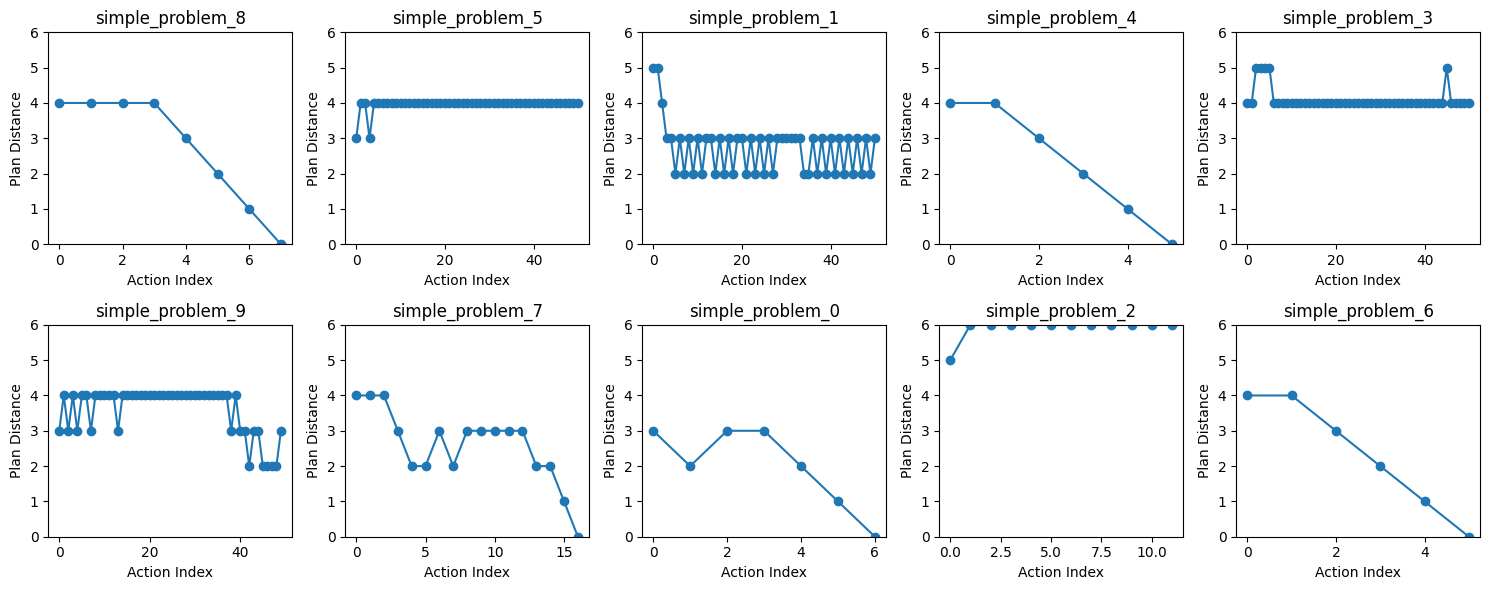

In [100]:
import math
import matplotlib.pyplot as plt

# Determine grid size
n_problems = len(problem_keys)
ncols = 5
nrows = math.ceil(n_problems / ncols)

fig, axes = plt.subplots(nrows, ncols, figsize=(15, 3 * nrows), squeeze=False)

# First pass: plot each problem and record the max y value
max_y_values = []
for idx, prob in enumerate(problem_keys):
    print(f"Problem {idx + 1}/{n_problems}: {prob}")
    prob_full_path = os.path.join(ROOT, prob)
    prob_results = results[prob]
    
    # Create environment and calculate goal distances 
    env_current = get_env(DOMAIN_PATH, prob_full_path)
    distances, _ = calculate_goal_distance(env_current, prob_results)
    
    local_max = max(distances) if distances else 0
    max_y_values.append(local_max)
    
    row = idx // ncols
    col = idx % ncols
    ax = axes[row, col]
    ax.plot(range(len(distances)), distances, marker='o')
    problem_name = prob.split('/')[-1].split('.')[0]
    ax.set_title(problem_name)
    ax.set_xlabel('Action Index')
    ax.set_ylabel('Plan Distance')
    ax.set_ylim(bottom=0)  # Set lower bound to 0

# Determine the global maximum y value across all subplots
global_max_y = max(max_y_values) if max_y_values else 0

# Second pass: update all subplots to have the same y-axis max
for idx in range(n_problems):
    row = idx // ncols
    col = idx % ncols
    axes[row, col].set_ylim(top=global_max_y)

# Hide empty subplots if any
for j in range(n_problems, nrows * ncols):
    row = j // ncols
    col = j % ncols
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()